# MNIST Inpainting with Energy-Based Learning

In this exercise, we consider the task of inpainting incomplete handwritten digits, and for this, we would like to make use of neural networks and the Energy-Based Learning framework.

In [1]:
import torch
import torch.nn as nn
import utils
import numpy
%matplotlib inline

As a first step, we load the MNIST dataset

In [2]:
Xr,Xt = utils.getdata()

We consider the following perturbation process that draws some region near the center of the image randomly and set the pixels in this area to some gray value.

In [3]:
def removepatch(X):
    mask = torch.zeros(len(X),28,28)
    for i in range(len(X)):
        j = numpy.random.randint(-4,5)
        k = numpy.random.randint(-4,5)
        mask[i,11+j:17+j,11+k:17+k] = 1
    mask = mask.view(len(X),784)
    return (X*(1-mask)).data,mask

The outcome of the perturbation process can be visualized below:

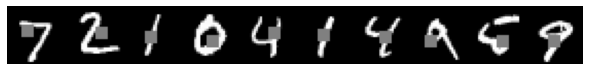

In [4]:
%matplotlib inline
xmask = removepatch(Xt[:10])[0]
utils.vis10(xmask)

## PCA Reconstruction (20 P)

A simple technique for impainting an image is principal component analysis. It consists of taking the incomplete image and projecting it on the $d$ principal components of the training data.

**Task:**
* **Implement a function that takes a collection of test examples `z` and projects them on the $d$ principal components of the training data `x`.**

In [5]:
import numpy as np


def pca(z,x,d):
    
    # -------------------------------
    # TODO: replace by your code
    # -------------------------------
#     import solution
#     y = solution.pca(z,x,d)
    
    # -------------------------------
    mean = x.mean(axis=0)
    # centered cov-mat
    C = (x - mean).T @ (x - mean)
    # eigenvalues and respective vectors (sorted ascending)
    w, v = np.linalg.eigh(C)
    # principal compnents
    p_d = v[:,-d:]
    # transform onto d principal components
    y = (z - mean) @ p_d
    # inverse transformation
    y = (y @ p_d.T) + mean
    return y

The PCA-based inpainting technique is tested below on 10 test points for which a patch is missing. We observe that the patch-like perturbation is less severe when $d$ is low, but the reconstructed part of the digit appears blurry. Conversely, if setting $d$ high, more details become available, but the missing pattern appears more prominent.

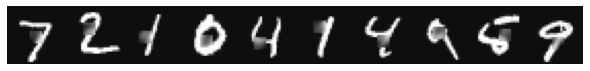

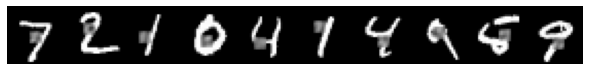

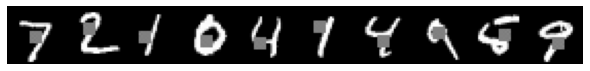

In [6]:
Xn,m = removepatch(Xt[:10])

utils.vis10(pca(Xn,Xr,10)*m+Xn*(1-m))
utils.vis10(pca(Xn,Xr,60)*m+Xn*(1-m))
utils.vis10(pca(Xn,Xr,360)*m+Xn*(1-m))

## Energy-Based Learning (20 P)

We now consider the energy-based learning framework where we learn an energy function to discriminate between correct and incorrect reconstructions.

In [7]:
torch.manual_seed(0)
enet = nn.Sequential(
    nn.Linear(784,256),nn.Hardtanh(),
    nn.Linear(256,256),nn.Hardtanh(),
    nn.Linear(256,1),
)

To be able to generate good contrastive examples (i.e. incorrect reconstructions that are still plausible enough to confuse the energy-based model and for which meaningful gradient signal can be extracted), we consider a generator network that takes as input the incomplete images.

In [8]:
gnet = nn.Sequential(
    nn.Linear(784,256),nn.Hardtanh(),
    nn.Linear(256,256),nn.Hardtanh(),
    nn.Linear(256,784),nn.Hardtanh()
)

The whole architecture is depicted in the diagram below:

![](diagram.png)

The two networks are then jointly optimized. The structure of the optimization problem is already provided to you, however, the code that computes the forward pass from the input data up to the error function are missing.

**Task:**

* **Write the code that computes the error function. Here, we use a single optimizer and must therefore implement the gradient flip trick described in the slides. A similar trick can be used to only let the gradient flow into the generator only via the missing image patch and not through all pixels.**

In [9]:
import torch.optim as optim

N = 10000
mb = 100

optimizer = optim.SGD(list(enet.parameters())+list(gnet.parameters()), lr=0.05)

for epoch in numpy.arange(100):

    for i in range(N//mb):

        optimizer.zero_grad()

        # Take a minibatch and train it
        x   = Xr[mb*i:mb*(i+1)].data*1.0
        z,m = removepatch(x)
        
        # Build the forward pass from the input until the loss function
        
        # -------------------------------
        # TODO: replace by your code
        # -------------------------------
#         import solution
#         err = solution.err(x,m,z,gnet,enet)
        G_Theta = gnet(z)
        gentrick = 2*G_Theta.data - G_Theta
        # apply generator model to the (masked) patches only and keep original image x for all others (inverse mask)
        gentrick = x*(1-m) + gentrick*m
        E_g = enet(gentrick)
        E_e = enet(x)
        # compute the log error
        err = torch.log(1 + torch.exp(E_e - E_g)).mean()
        # -------------------------------
        
        # Compute the gradient and perform one step of gradient descent
        err.backward()
        optimizer.step()
        
    if epoch%10==0: print(epoch,err)


0 tensor(0.6745, grad_fn=<MeanBackward0>)
10 tensor(0.1769, grad_fn=<MeanBackward0>)
20 tensor(0.2126, grad_fn=<MeanBackward0>)
30 tensor(0.3146, grad_fn=<MeanBackward0>)
40 tensor(0.3398, grad_fn=<MeanBackward0>)
50 tensor(0.3794, grad_fn=<MeanBackward0>)
60 tensor(0.4388, grad_fn=<MeanBackward0>)
70 tensor(0.4329, grad_fn=<MeanBackward0>)
80 tensor(0.4795, grad_fn=<MeanBackward0>)
90 tensor(0.4312, grad_fn=<MeanBackward0>)


After optimizing for a sufficient number of epochs, the solution has ideally come close to some nash equilibrium where both the generator and energy-based model perform well. In particular, the generator should generate examples that look similar to the true examples. The code below plots the incomplete digits and the reconstruction obtained by the generator network.

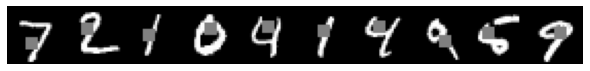

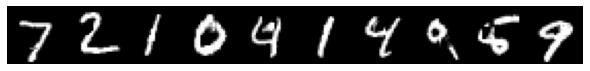

In [10]:
x = Xt[:10]
z,m = removepatch(x)
utils.vis10(z)
utils.vis10(gnet(z)*m+z*(1-m))

As we can see, although some artefacts still persist, the reconstructions are quite plausible and look better than those one gets with the simple PCA-based approach. Note however that the procedure is also more complex and computationally more demanding than a simple PCA-based reconstruction.